In [1]:
import os
import xarray as xr
from tqdm import tqdm 
import numpy as np
import ultraplot as uplt
# Interpolating u over time
from scipy.interpolate import interp1d, RegularGridInterpolator
from joblib import Parallel, delayed
# from functools import lru_cache

import sys
sys.path.append('src/lagranto_tracking')
from lagranto_track import *

### single points

In [2]:
# settings
seconds_one_sol = 24 * 60 * 60 + 39 * 60 + 35.244 # seconds per sol
steps_per_delta_time = 2 ### steps per delta time, should be an even number
radius = 3396200 # unit from km to m
p0 = 710
g = 3.71
H = 10 # scale height in km

In [3]:
### read LMD DATA, it defines the time range we are care about
data_dir = '/mnt/nas/cc1/Mars_PCM/util_MY36_lagranto' ### can be slow, so we should use the local data, you can copy to you local directory
file_name = 'concat_P_month_5.nc'
ds = xr.open_dataset(os.path.join(data_dir,file_name),decode_times=False)
ds

<xarray.Dataset> Size: 15GB
Dimensions:    (index: 100, GCM_layers: 73, latitude: 49, longitude: 65,
                Time: 1440, altitude: 91)
Coordinates:
  * latitude   (latitude) float32 196B 90.0 86.25 82.5 ... -82.5 -86.25 -90.0
  * longitude  (longitude) float32 260B -180.0 -174.4 -168.8 ... 174.4 180.0
  * Time       (Time) float32 6kB 258.0 258.1 258.1 258.2 ... 317.9 318.0 318.0
  * altitude   (altitude) float32 364B 1.006e+03 887.5 783.3 ... 0.01482 0.01308
Dimensions without coordinates: index, GCM_layers
Data variables: (12/16)
    controle   (index) float32 400B ...
    aps        (GCM_layers) float32 292B ...
    bps        (GCM_layers) float32 292B ...
    phisinit   (latitude, longitude) float32 13kB ...
    ps         (Time, latitude, longitude) float32 18MB ...
    zareoid    (Time, altitude, latitude, longitude) float32 2GB ...
    ...         ...
    w          (Time, altitude, latitude, longitude) float32 2GB ...
    rho        (Time, altitude, latitude, longitude) float32 2GB ...
    h2o_ice    (Time, altitude, latitude, longitude) float32 2GB ...
    h2o_vap    (Time, altitude, latitude, longitude) float32 2GB ...
    dustq      (Time, altitude, latitude, longitude) float32 2GB ...
    Ls         (Time) float32 6kB ...
Attributes:
    history:                    Mon Dec  2 19:47:19 2024: ncks -A -v Ls conca...
    history_of_appended_files:  Mon Dec  2 19:47:19 2024: Appended file conca...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [4]:
lon = ds['longitude'].values
lat = ds['latitude'].values
pres = ds['altitude'].values ### unit in Pa in this case
time = ds['Time'].values
u = ds['u'].values
v = ds['v'].values
w = ds['w'].values
# rho = ds['rho'].values
h2o_vap = ds['h2o_vap'].values
temp = ds['temp'].values
# ps = ds['ps'].values # we can just use the interped u,v,w to judge the lower boundary
time_array = time * seconds_one_sol # unit from days to seconds

alt = pres2alt(pres,p0,H)*1000 # unit from Pa to m
w = -w # positive w is downward in original data


lat = np.flip(lat)
u = np.flip(u, axis=2)
v = np.flip(v, axis=2)
w = np.flip(w, axis=2)
h2o_vap = np.flip(h2o_vap, axis=2)
temp = np.flip(temp, axis=2)

In [5]:
new_time_points = np.linspace(time_array[0], time_array[-1], (len(time_array) - 1) * steps_per_delta_time + 1)
time_delta_in_seconds = new_time_points[1] - new_time_points[0]
print(time_delta_in_seconds, new_time_points.shape)

1850.0 (2879,)


In [6]:
### interp the time series to the new time points with time step of steps_per_delta_time,

### interpolate the data to the new time points

### track the particles from these data, so the data also defines the time range we are care about

### fast linear interpolation here
u_time_interp = interpolate_4d_time(u, time_array, new_time_points)
v_time_interp = interpolate_4d_time(v, time_array, new_time_points)
w_time_interp = interpolate_4d_time(w, time_array, new_time_points)
h2o_vap_time_interp = interpolate_4d_time(h2o_vap, time_array, new_time_points)
temp_time_interp = interpolate_4d_time(temp, time_array, new_time_points)

In [7]:
lower_boundary = 0
upper_boundary = alt.max()

print(f"lower_boundary: {lower_boundary/1000:.2f} km, upper_boundary: {upper_boundary/1000:.2f} km")

lower_boundary: 0.00 km, upper_boundary: 109.02 km


In [8]:
#### give some point to track
clon = 0
clat = 0
calt = 40*1e3 # unit in m

cilon = np.argmin(np.abs(lon - clon))
cilat = np.argmin(np.abs(lat - clat))
cialt = np.argmin(np.abs(alt - calt))

print(cilon, cilat, cialt)

need_track_initial_points = [(clon, clat, cialt)] # points we need to track
# need_track_initial_points.append((clon, clat, alt2pres(1,p0,H)))
# need_track_initial_points.append((0, 0, alt2pres(30,p0,H)))
# need_track_initial_points.append((0, 30, alt2pres(50,p0,H)))
need_track_initial_points.append((clon, clat, calt))
trajectory_dict = {} # dict of initial points in trajectory, 
for point_lon, point_lat, point_pres in need_track_initial_points:
	trajectory_dict[point_lon, point_lat, point_pres] = (point_lon, point_lat, point_pres)
	print('add ', point_lon, point_lat, point_pres)

32 24 35
add  0 0 35
add  0 0 40000.0


In [9]:
def plot_trajectory(new_position_dict_list, start_points=None,time=None):
	# u_wind = []
	# v_wind = []
	# w_wind = []
	# for new_position_dict in new_position_dict_list:
	# 	for point_lon, point_lat, point_pres in new_position_dict.keys():
	# 		u_value, v_value, w_value = wind_dict[point_lon, point_lat, point_pres]
	# 		u_wind.append(u_value)
	# 		v_wind.append(v_value)
	# 		w_wind.append(w_value)
	
	lon_array = np.array([])
	lat_array = np.array([])
	alt_array = np.array([])

	plot_points = list(new_position_dict_list[0].keys())[-1]
	if start_points is None:
		start_points = list(new_position_dict_list[0].keys())[-1]
	for new_position_dict in tqdm(new_position_dict_list):
		lons, lats, alts = new_position_dict[plot_points]
		lon_array = np.append(lon_array, lons)
		lat_array = np.append(lat_array, lats)
		alt_array = np.append(alt_array, alts)

	fig, axs = uplt.subplots(ncols=2,nrows=2, figsize=(10, 6),share=False, hratios=(1,0.5))
	ax = axs[0]
	sc = ax.scatter(lon_array, lat_array, c=alt_array/1000, cmap='rainbow', s=15)
	ax.colorbar(sc, ax=ax, label='Altitude (km)')
	ax.scatter(start_points[0], start_points[1],  color='black',marker='+', label='Start Point', s=125)
	ax.scatter(lon_array[~np.isinf(lon_array)][-1], lat_array[~np.isinf(lat_array)][-1], marker='x', color='black', label='End Point', s=125)
	ax.set_xlim(-180,180)
	ax.set_ylim(-90,90)
	ax.legend(loc='t')
	ax.format(xlabel='longitude',ylabel='latitude',xformatter='deglon',yformatter='deglat',\
		  fontsize=20,title='Lagrangian trajectory in lon x lat plane',ylocator=30)

	# ax = axs[1]
	# ax.plot(u_wind,c='r')
	# ax.legend(loc='t')
	# ax.format(xlabel='time (sol)',ylabel='zonal wind speed (m/s)')

	# ax = axs[2]
	# ax.plot(v_wind,c='b')
	# ax.legend(loc='t')
	# ax.format(xlabel='time (sol)',ylabel='meridional wind speed (m/s)')

	ax = axs[1]
	ax.plot(time, alt_array/1000,c='g',label='Altitude')
	ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='altitude (km)',title='Altitude vs time')


	ax = axs[2]
	ax.scatter(time, lon_array, c='b',label='lon',s=1)
	# ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='longitude',title='longitude vs time')


	ax = axs[3]
	ax.scatter(time, lat_array, c='m',label='lat',s=1)
	# ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='latitude',title='latitude vs time')
	fig.format(abc=True,fontsize=12)

### midpoint method

In [10]:
mid_fwd_steps = track_particles_midpoint(
    time=new_time_points,
    u_time_interp=u_time_interp,
    v_time_interp=v_time_interp,
    w_time_interp=w_time_interp,
    need_track_initial_points=need_track_initial_points,
    alt_grid_m=alt,
    lat_grid=lat,
    lon_grid=lon,
    lower_boundary=lower_boundary,
    upper_boundary=upper_boundary,
    radius=3396200,
    verbose=True,
    w_positive_up=True,              # 按你的数据定义调整
    lon_mode=None,                   # 自动根据 lon_grid 推断
    picard_iters=3,
    picard_tol=None,                 # 例如可设为 (1e-8, 1e-8, 1e-4)
    use_slerp_midpoint=True,
)

# 与每个步长对应的时间戳（长度为 len(time)-1）
trace_times_fwd = get_trace_time_midpoint(new_time_points)

Midpoint integration along time axis: 100%|██████████| 2878/2878 [00:04<00:00, 696.68it/s] 


100%|██████████| 2878/2878 [00:00<00:00, 74231.82it/s]


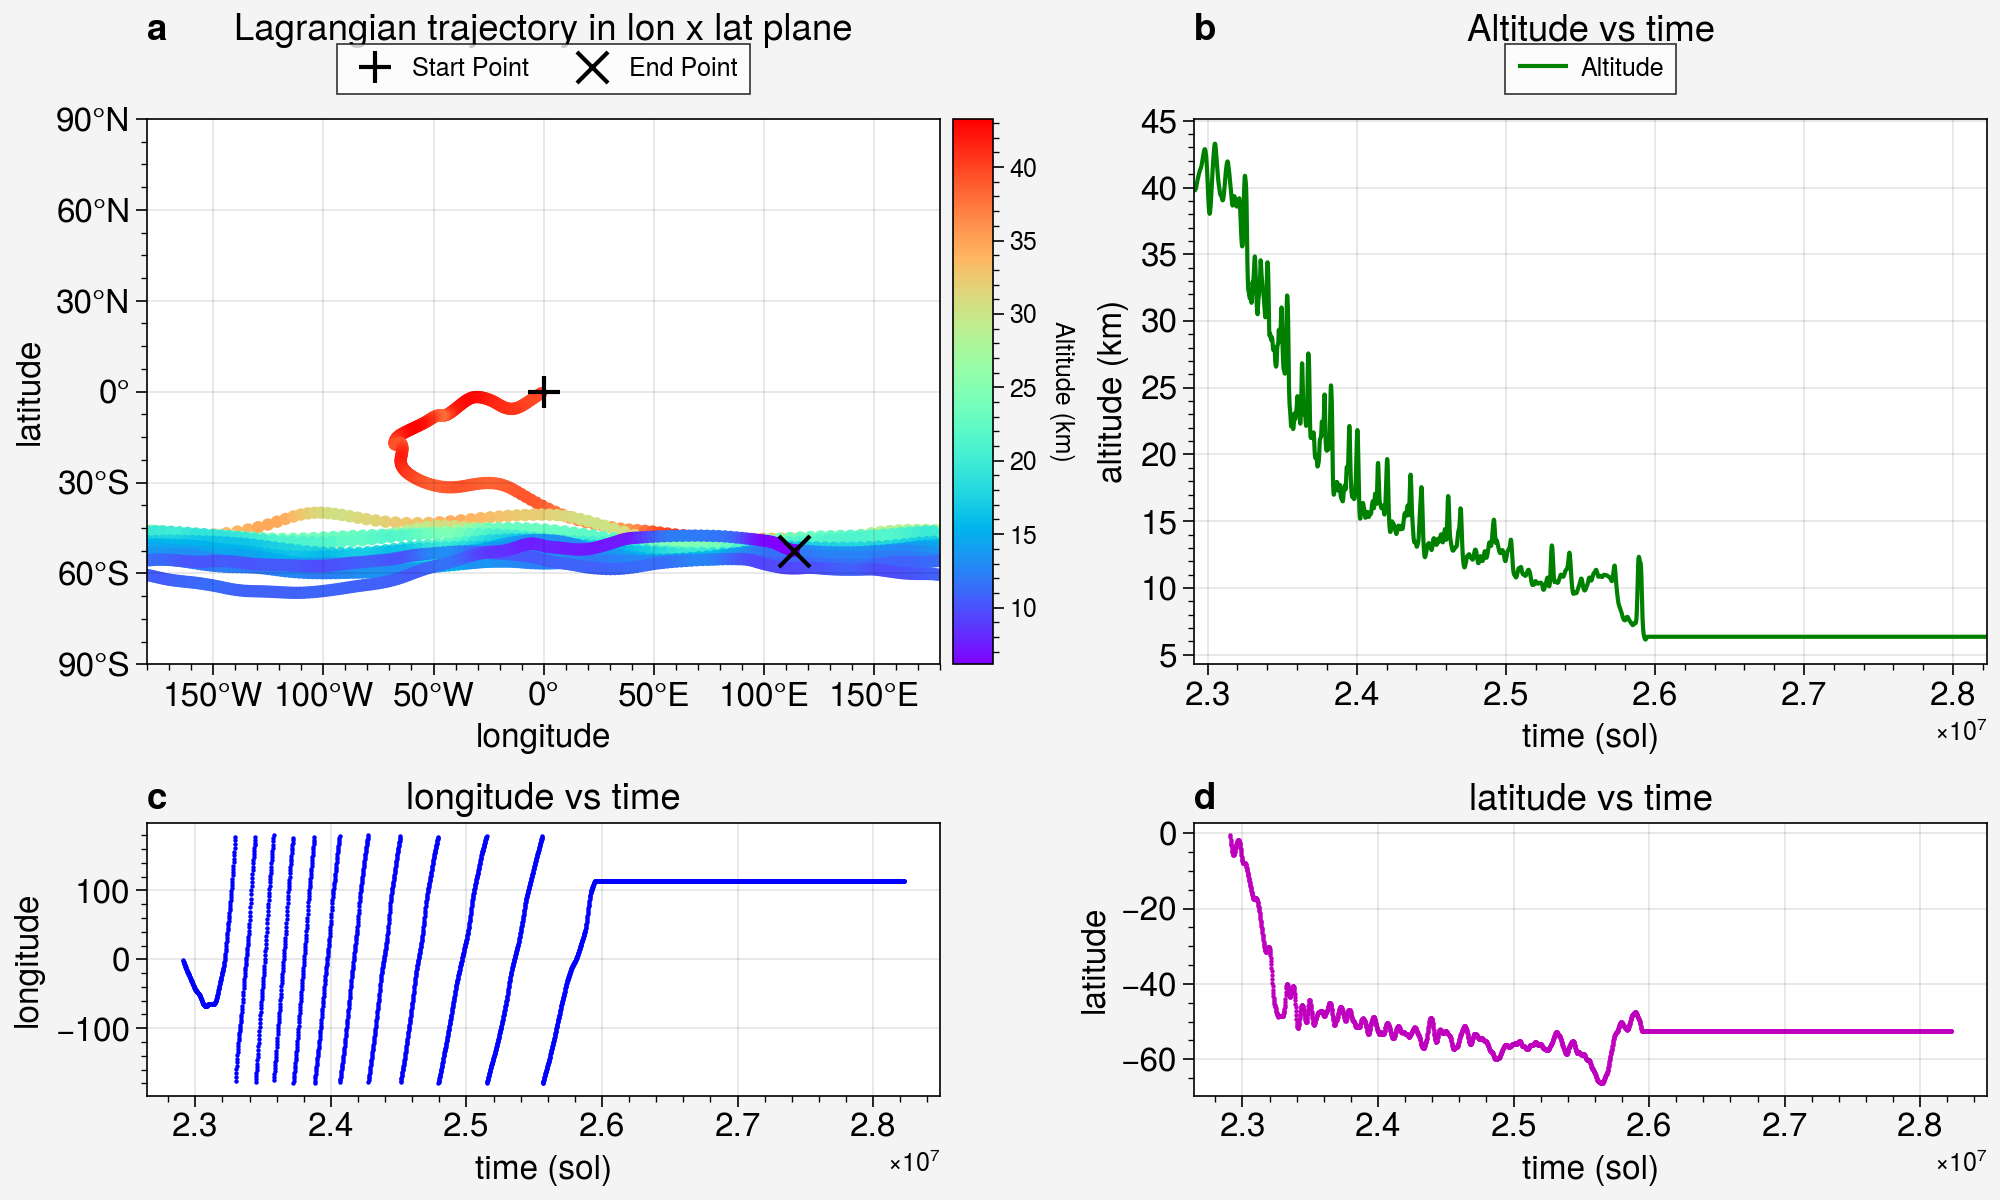

In [11]:
plot_trajectory(mid_fwd_steps, start_points=None,time = trace_times_fwd)

In [ ]:
h2ovap_fwd_steps = sample_scalar_on_midpoint_steps(mid_fwd_steps, h2o_vap_time_interp, alt, lat, lon, lon_mode=None)

In [14]:
h2ovap_fwd_steps[0]

{(0, 0, np.int64(35)): nan, (0, 0, 40000.0): 5.626320619110557e-06}

In [ ]:
def plot_trajectory_with_scalar(
    new_position_dict_list,
    scalar_steps,
    start_points=None,
    time=None,
    scalar_name='H2O vapor',
    scalar_units='',
    cmap='viridis',
    vmin=None,
    vmax=None,
    norm=None,
    s=15,
    mask_nan=True,
    lon_xlim=(-180, 180),
    lat_ylim=(-90, 90),
    log_colorbar=False,
):
    # Basic checks
    if len(scalar_steps) != len(new_position_dict_list):
        raise ValueError('scalar_steps and position steps must have the same length')
    if time is None or len(time) != len(new_position_dict_list):
        raise ValueError('time must be provided and match the number of steps')

    # Choose seed to plot (same rule as your original function)
    plot_key = list(new_position_dict_list[0].keys())[-1] if start_points is None else start_points

    # Collect arrays
    lon_array = np.array([])
    lat_array = np.array([])
    alt_array = np.array([])
    scalar_array = np.array([])

    for i, pos_dict in enumerate(new_position_dict_list):
        lon, lat, alt = pos_dict[plot_key]
        lon_array = np.append(lon_array, lon)
        lat_array = np.append(lat_array, lat)
        alt_array = np.append(alt_array, alt)

        val = scalar_steps[i].get(plot_key, np.nan)
        scalar_array = np.append(scalar_array, val)

    # Ultraplot-only backend
    # import ultraplot as uplt
    fig, axs = uplt.subplots(ncols=2, nrows=2, figsize=(10, 6), share=False, hratios=(1, 0.5))

    # Prepare color data and norm
    cdata = np.ma.masked_invalid(scalar_array) if mask_nan else scalar_array
    color_norm = norm
    if log_colorbar:
        from matplotlib.colors import LogNorm
        vals = np.asarray(scalar_array, dtype=float)
        valid = np.isfinite(vals) & (vals > 0)
        if vmin is None or vmax is None:
            if not np.any(valid):
                raise ValueError('log_colorbar=True requires positive finite values (or set positive vmin/vmax).')
            vmin_ = float(vmin) if vmin is not None else float(np.min(vals[valid]))
            vmax_ = float(vmax) if vmax is not None else float(np.max(vals[valid]))
        else:
            vmin_ = float(vmin)
            vmax_ = float(vmax)
        if not (vmin_ > 0 and vmax_ > 0 and vmax_ > vmin_):
            raise ValueError('For log_colorbar, vmin and vmax must be positive and vmax > vmin.')
        color_norm = LogNorm(vmin=vmin_, vmax=vmax_)

    # Panel a: lon-lat colored by scalar
    ax = axs[0]
    sc = ax.scatter(lon_array, lat_array, c=cdata, cmap=cmap, vmin=None if color_norm else vmin,
                    vmax=None if color_norm else vmax, norm=color_norm, s=s)
    label = f'{scalar_name} ({scalar_units})' if scalar_units else scalar_name
    ax.colorbar(sc, label=label)

    # Start / end markers
    start_lon, start_lat = plot_key[0], plot_key[1]
    ax.scatter(start_lon, start_lat, color='black', marker='+', label='Start Point', s=125)
    ax.scatter(lon_array[~np.isinf(lon_array)][-1], lat_array[~np.isinf(lat_array)][-1],
               marker='x', color='black', label='End Point', s=125)

    ax.set_xlim(*lon_xlim)
    ax.set_ylim(*lat_ylim)
    ax.legend(loc='t')
    ax.format(xlabel='longitude', ylabel='latitude',
              xformatter='deglon', yformatter='deglat',
              fontsize=20, title=f'Lagrangian trajectory (colored by {scalar_name})', ylocator=30)

    # Panel b: altitude vs time
    ax = axs[1]
    ax.plot(time, alt_array/1000, c='g', label='Altitude')
    ax.legend(loc='t')
    ax.format(xlabel='time (sol)', ylabel='altitude (km)', title='Altitude vs time')

    # Panel c: longitude vs time
    ax = axs[2]
    ax.scatter(time, lon_array, c='b', s=1, label='lon')
    ax.format(xlabel='time (sol)', ylabel='longitude', title='longitude vs time')

    # Panel d: latitude vs time
    ax = axs[3]
    ax.scatter(time, lat_array, c='m', s=1, label='lat')
    ax.format(xlabel='time (sol)', ylabel='latitude', title='latitude vs time')

    fig.format(abc=True, fontsize=12)
    return fig, axs


(Figure(nrows=2, ncols=2, figwidth=np.float64(10.0), figheight=np.float64(6.0)),
 SubplotGrid(nrows=2, ncols=2, length=4))

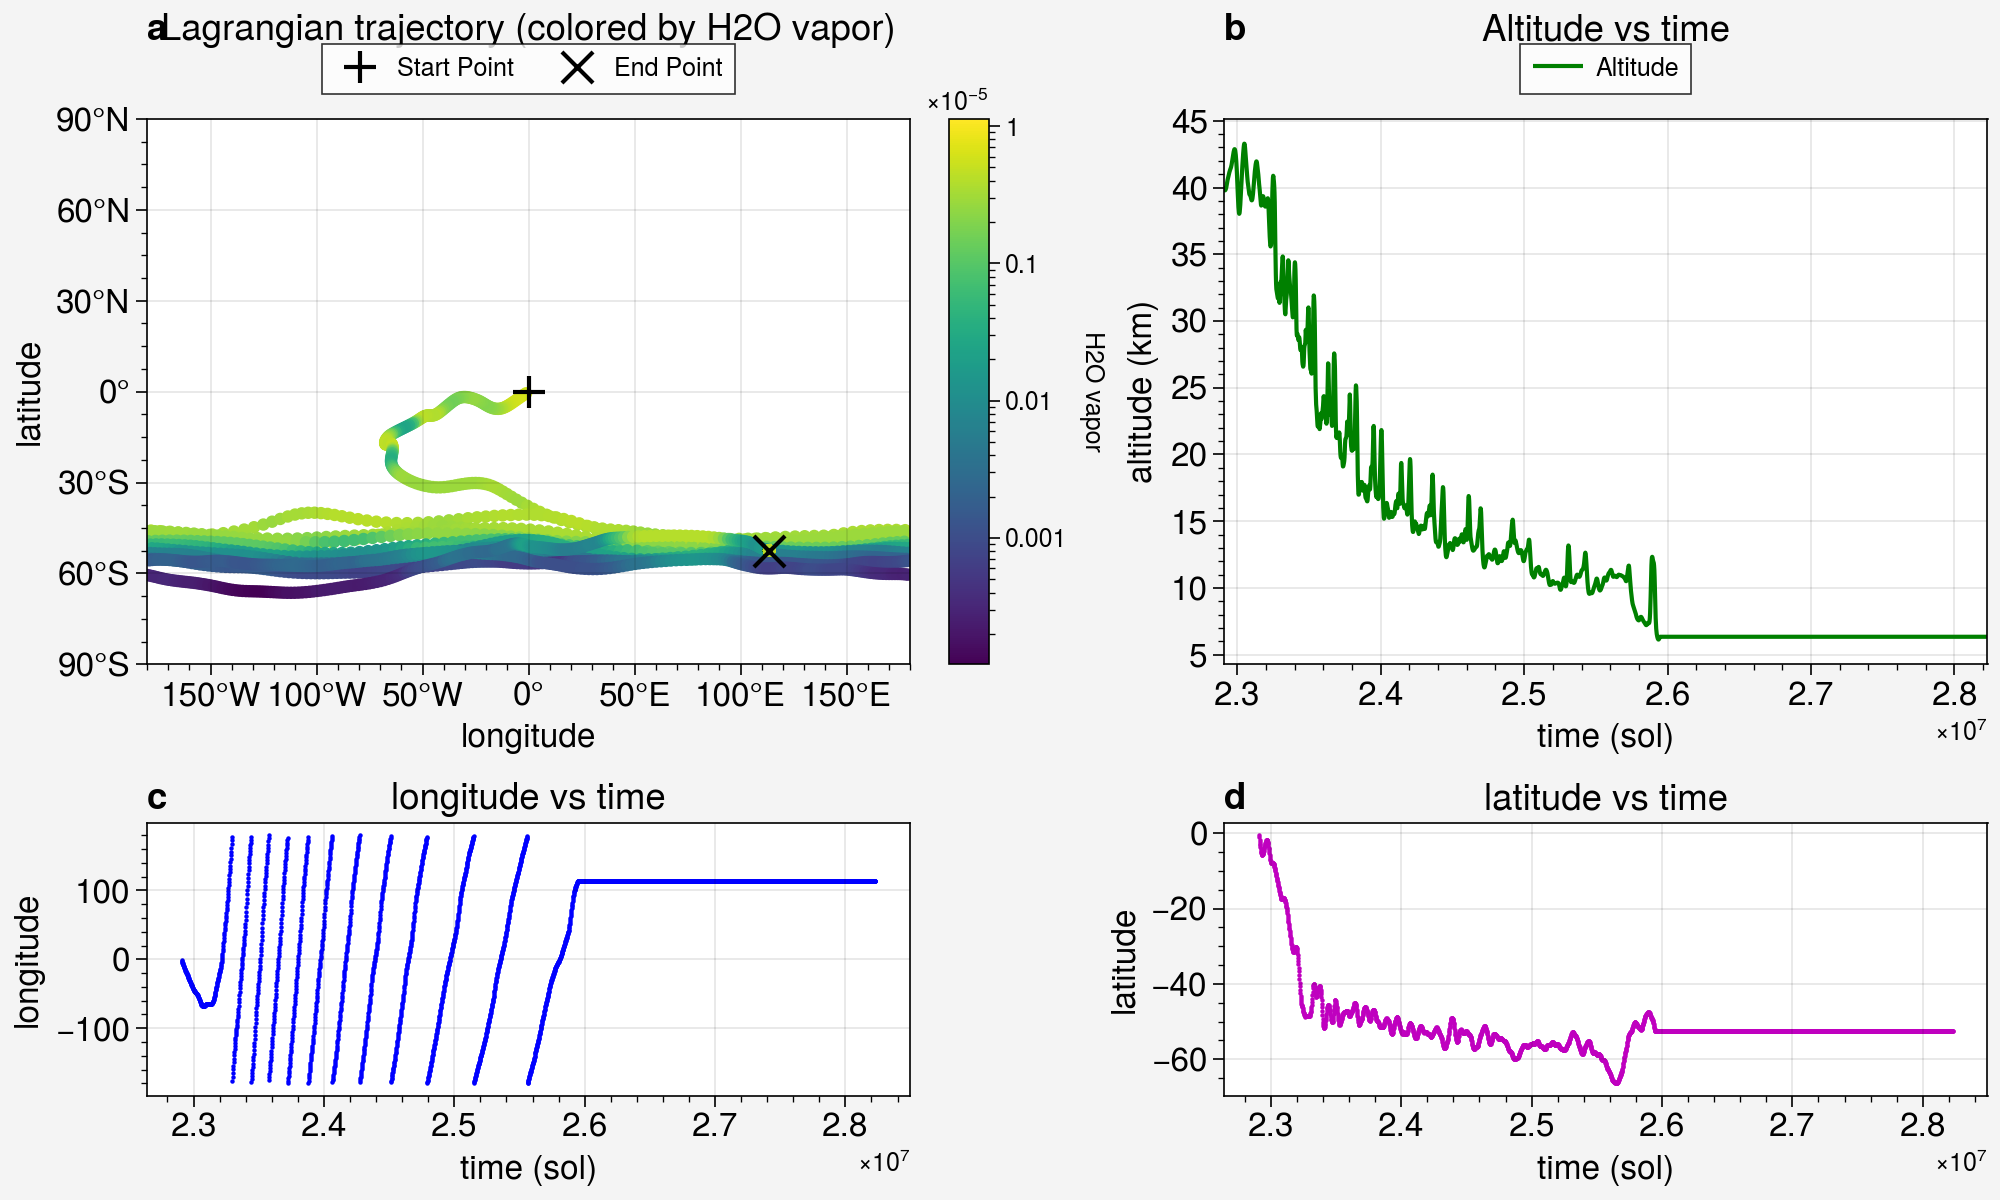

In [26]:
plot_trajectory_with_scalar(
    mid_fwd_steps,
    h2ovap_fwd_steps,
    start_points=None,
    time=trace_times_fwd,
    scalar_name='H2O vapor',
    scalar_units='',
    cmap='viridis',
    vmin=None,
    vmax=None,
    norm=None,
    s=15,
    mask_nan=True,
	log_colorbar=True
)

In [22]:
len(mid_fwd_steps),len(new_time_points)

(2878, 2879)